# Problem Statement Definition

Create a Recommender System to show personalized movie recommendations based on ratings given by a user and other users similar to them in order to improve user experience.

# Load libraries and data

In [1]:
# import libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

import time
import random

from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix

from sklearn.neighbors import NearestNeighbors

from cmfrec import CMF
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse

from surprise import KNNWithMeans 
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise import Reader

from surprise import SVD
from surprise.model_selection import cross_validate

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# Set Options
warnings.simplefilter('ignore')
pd.set_option("display.max_columns", None)
pd.options.display.float_format = '{:.2f}'.format
sns.set_style('white')

In [3]:
movies_df = pd.read_fwf('zee-movies.dat', encoding='ISO-8859-1')
movies_df.head()

,Movie ID::Title::Genres,Unnamed: 1,Unnamed: 2
0,1::Toy Story (1995)::Animation|Children's|Comedy,NaN,NaN
1,2::Jumanji (1995)::Adventure|Children's|Fantasy,NaN,NaN
2,3::Grumpier Old Men (1995)::Comedy|Romance,NaN,NaN
3,4::Waiting to Exhale (1995)::Comedy|Drama,NaN,NaN
4,5::Father of the Bride Part II (1995)::Comedy,NaN,NaN


In [4]:
users_df = pd.read_fwf('zee-users.dat', encoding='ISO-8859-1')
users_df.head()

,UserID::Gender::Age::Occupation::Zip-code
0,1::F::1::10::48067
1,2::M::56::16::70072
2,3::M::25::15::55117
3,4::M::45::7::02460
4,5::M::25::20::55455


In [5]:
ratings_df = pd.read_fwf('zee-ratings.dat', encoding='ISO-8859-1')
ratings_df.head()

,UserID::MovieID::Rating::Timestamp
0,1::1193::5::978300760
1,1::661::3::978302109
2,1::914::3::978301968
3,1::3408::4::978300275
4,1::2355::5::978824291


# Formatting the data

In [6]:
movies_df = movies_df['Movie ID::Title::Genres'].str.split('::', expand=True)
movies_df.columns = ['MovieID','Title','Genres']
movies_df.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
users_df = users_df['UserID::Gender::Age::Occupation::Zip-code'].str.split('::', expand=True)
users_df.columns = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code']
users_df.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [8]:
u = users_df.copy()

In [9]:
ratings_df = ratings_df['UserID::MovieID::Rating::Timestamp'].str.split('::', expand=True)
ratings_df.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [10]:
users_df.replace({'Age': {
    '1': "Under 18",
    '18': "18-24",
    '25': "25-34",
    '35': "35-44",
    '45': "45-49",
    '50': "50-55",
    '56': "56+"
}}, inplace=True)

In [11]:
users_df.replace({
    'Occupation': {
        '0': "other",
        '1': "academic/educator",
        '2': "artist",
        '3': "clerical/admin",
        '4': "college/grad student",
        '5': "customer service",
        '6': "doctor/health care",
        '7': "executive/managerial",
        '8': "farmer",
        '9': "homemaker",
        '10': "K-12 student",
        '11': "lawyer",
        '12': "programmer",
        '13': "retired",
        '14': "sales/marketing",
        '15': "scientist",
        '16': "self-employed",
        '17': "technician/engineer",
        '18': "tradesman/craftsman",
        '19': "unemployed",
        '20': "writer"
    }
}, inplace=True)

In [12]:
users_df.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,Under 18,K-12 student,48067
1,2,M,56+,self-employed,70072
2,3,M,25-34,scientist,55117
3,4,M,45-49,executive/managerial,02460
4,5,M,25-34,writer,55455


In [13]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   UserID     1000209 non-null  object
 1   MovieID    1000209 non-null  object
 2   Rating     1000209 non-null  object
 3   Timestamp  1000209 non-null  object
dtypes: object(4)
memory usage: 30.5+ MB


In [14]:
ratings_df['Timestamp'] = ratings_df['Timestamp'].astype('int')

In [15]:
ratings_df['Timestamp'] = ratings_df['Timestamp'].apply(lambda x: time.strftime("%d/%m/%Y %H:%M:%S", time.gmtime(x)))

In [16]:
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,31/12/2000 22:12:40
1,1,661,3,31/12/2000 22:35:09
2,1,914,3,31/12/2000 22:32:48
3,1,3408,4,31/12/2000 22:04:35
4,1,2355,5,06/01/2001 23:38:11


In [17]:
ratings_df['Timestamp'] = pd.to_datetime(ratings_df['Timestamp'])

In [18]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   UserID     1000209 non-null  object        
 1   MovieID    1000209 non-null  object        
 2   Rating     1000209 non-null  object        
 3   Timestamp  1000209 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 30.5+ MB


In [19]:
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-06-01 23:38:11


# Merging the data files 

In [20]:
df = pd.merge(movies_df, ratings_df, on='MovieID')

In [21]:
df = pd.merge(df, users_df, on='UserID')

In [22]:
df

,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,2001-06-01 23:37:48,F,Under 18,K-12 student,48067
1,48,Pocahontas (1995),Animation|Children's|Musical|Romance,1,5,2001-06-01 23:39:11,F,Under 18,K-12 student,48067
2,150,Apollo 13 (1995),Drama,1,5,2000-12-31 22:29:37,F,Under 18,K-12 student,48067
3,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantas,1,4,2000-12-31 22:12:40,F,Under 18,K-12 student,48067
4,527,Schindler's List (1993),Drama|War,1,5,2001-06-01 23:36:35,F,Under 18,K-12 student,48067
...,...,...,...,...,...,...,...,...,...,...
1000204,3513,Rules of Engagement (2000),Drama|Thriller,5727,4,2000-05-16 15:12:50,M,25-34,college/grad student,92843
1000205,3535,American Psycho (2000),Comedy|Horror|Thriller,5727,2,2000-05-16 15:12:50,M,25-34,college/grad student,92843
1000206,3536,Keeping the Faith (2000),Comedy|Romance,5727,5,2000-05-16 15:11:42,M,25-34,college/grad student,92843
1000207,3555,U-571 (2000),Action|Thriller,5727,3,2000-05-16 15:24:59,M,25-34,college/grad student,92843


# Performing EDA, Data Cleaning, and Feature Engineering

### Reviewing the shape and structure of the dataset

In [23]:
df.shape

(1000209, 10)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 0 to 1000208
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   MovieID     1000209 non-null  object        
 1   Title       1000209 non-null  object        
 2   Genres      996144 non-null   object        
 3   UserID      1000209 non-null  object        
 4   Rating      1000209 non-null  object        
 5   Timestamp   1000209 non-null  datetime64[ns]
 6   Gender      1000209 non-null  object        
 7   Age         1000209 non-null  object        
 8   Occupation  1000209 non-null  object        
 9   Zip-code    1000209 non-null  object        
dtypes: datetime64[ns](1), object(9)
memory usage: 83.9+ MB


In [25]:
movies_df.shape

(3883, 3)

In [26]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   MovieID  3883 non-null   object
 1   Title    3883 non-null   object
 2   Genres   3858 non-null   object
dtypes: object(3)
memory usage: 91.1+ KB


In [27]:
movies_df.describe()

,MovieID,Title,Genres
count,3883,3883,3858
unique,3883,3883,360
top,1,Toy Story (1995),Drama
freq,1,1,830


In [28]:
users_df.shape

(6040, 5)

In [29]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   UserID      6040 non-null   object
 1   Gender      6040 non-null   object
 2   Age         6040 non-null   object
 3   Occupation  6040 non-null   object
 4   Zip-code    6040 non-null   object
dtypes: object(5)
memory usage: 236.1+ KB


In [30]:
users_df.describe()

,UserID,Gender,Age,Occupation,Zip-code
count,6040,6040,6040,6040,6040
unique,6040,2,7,21,3439
top,1,M,25-34,college/grad student,48104
freq,1,4331,2096,759,19


In [31]:
ratings_df.shape

(1000209, 4)

In [32]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   UserID     1000209 non-null  object        
 1   MovieID    1000209 non-null  object        
 2   Rating     1000209 non-null  object        
 3   Timestamp  1000209 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 30.5+ MB


In [33]:
ratings_df.describe()

,UserID,MovieID,Rating,Timestamp
count,1000209,1000209,1000209,1000209
unique,6040,3706,5,458455
top,4169,2858,4,2000-11-29 20:06:42
freq,2314,3428,348971,30
first,NaN,NaN,NaN,2000-01-05 00:33:20
last,NaN,NaN,NaN,2003-12-02 21:36:43


In [34]:
movies_df[movies_df['Genres'].isna()]['Title']

62      Don't Be a Menace to South Central While Drink...
197     Umbrellas of Cherbourg, The (Parapluies de Che...
359     Wonderful, Horrible Life of Leni Riefenstahl, ...
464     Englishman Who Went Up a Hill, But Came Down a...
720     Institute Benjamenta, or This Dream People Cal...
740     Dr. Strangelove or: How I Learned to Stop Worr...
783     My Life and Times With Antonin Artaud (En comp...
787     Old Lady Who Walked in the Sea, The (Vieille q...
1134    Return of Martin Guerre, The (Retour de Martin...
1160    Double Life of Veronique, The (La Double Vie d...
1341    Garden of Finzi-Contini, The (Giardino dei Fin...
1950    Seven Samurai (The Magnificent Seven) (Shichin...
2170    Swept Away (Travolti da un insolito destino ne...
2516    Lovers of the Arctic Circle, The (Los Amantes ...
2522    Jeanne and the Perfect Guy (Jeanne et le garço...
2563    Saragossa Manuscript, The (Rekopis znaleziony ...
2721    Final Conflict, The (a.k.a. Omen III: The Fina...
3001    Advent

In [35]:
movies_df.loc[62]['Title']

"Don't Be a Menace to South Central While Drinking Your Juice in the"

In [36]:
# Extracting new feature release year from the title part
movies_df['Release Year'] = movies_df['Title'].str.extract(r'\((\d+)\)', expand=True)

In [37]:
# Removing the release year from titles
movies_df['Title'] = movies_df['Title'].str.replace(r'(\(\d+)\)','').str.strip()

In [38]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   MovieID       3883 non-null   object
 1   Title         3883 non-null   object
 2   Genres        3858 non-null   object
 3   Release Year  3864 non-null   object
dtypes: object(4)
memory usage: 121.5+ KB


### Missing value checks and imputation

In [39]:
movies_df[movies_df['Release Year'].isna()]

,MovieID,Title,Genres,Release Year
62,63,Don't Be a Menace to South Central While Drink...,None,NaN
359,363,"Wonderful, Horrible Life of Leni Riefenstahl, ...",None,NaN
464,468,"Englishman Who Went Up a Hill, But Came Down a...",None,NaN
740,750,Dr. Strangelove or: How I Learned to Stop Worr...,None,NaN
783,793,My Life and Times With Antonin Artaud (En comp...,None,NaN
787,797,"Old Lady Who Walked in the Sea, The (Vieille q...",None,NaN
1341,1362,"Garden of Finzi-Contini, The (Giardino dei Fin...",None,NaN
1950,2019,Seven Samurai (The Magnificent Seven) (Shichin...,None,NaN
2170,2239,Swept Away (Travolti da un insolito destino ne...,None,NaN
2516,2585,"Lovers of the Arctic Circle, The (Los Amantes ...",None,NaN


In [40]:
movies_df['Release Year'].value_counts()

1996    344
1995    341
1998    333
1997    315
1999    283
       ... 
1923      3
1919      3
1922      2
1920      2
1921      1
Name: Release Year, Length: 81, dtype: int64

In [41]:
np.count_nonzero(((movies_df['Release Year'].value_counts() > 1).values * 1) == 0)

1

In [42]:
movies_df[movies_df['Release Year'].isna()]

,MovieID,Title,Genres,Release Year
62,63,Don't Be a Menace to South Central While Drink...,None,NaN
359,363,"Wonderful, Horrible Life of Leni Riefenstahl, ...",None,NaN
464,468,"Englishman Who Went Up a Hill, But Came Down a...",None,NaN
740,750,Dr. Strangelove or: How I Learned to Stop Worr...,None,NaN
783,793,My Life and Times With Antonin Artaud (En comp...,None,NaN
787,797,"Old Lady Who Walked in the Sea, The (Vieille q...",None,NaN
1341,1362,"Garden of Finzi-Contini, The (Giardino dei Fin...",None,NaN
1950,2019,Seven Samurai (The Magnificent Seven) (Shichin...,None,NaN
2170,2239,Swept Away (Travolti da un insolito destino ne...,None,NaN
2516,2585,"Lovers of the Arctic Circle, The (Los Amantes ...",None,NaN


In [43]:
movies_df[movies_df['Genres'].isna()]

,MovieID,Title,Genres,Release Year
62,63,Don't Be a Menace to South Central While Drink...,None,NaN
197,199,"Umbrellas of Cherbourg, The (Parapluies de Che...",None,1964
359,363,"Wonderful, Horrible Life of Leni Riefenstahl, ...",None,NaN
464,468,"Englishman Who Went Up a Hill, But Came Down a...",None,NaN
720,729,"Institute Benjamenta, or This Dream People Cal...",None,1995
740,750,Dr. Strangelove or: How I Learned to Stop Worr...,None,NaN
783,793,My Life and Times With Antonin Artaud (En comp...,None,NaN
787,797,"Old Lady Who Walked in the Sea, The (Vieille q...",None,NaN
1134,1150,"Return of Martin Guerre, The (Retour de Martin...",None,1982
1160,1176,"Double Life of Veronique, The (La Double Vie d...",None,1991


movies_df.iloc[62]['Release Year'] = '1996'
movies_df.iloc[62]['Genres'] = 'Comedy|Crime'

movies_df.iloc[197]['Genres'] = 'Musical|Romance'

movies_df.iloc[359]['Release Year'] = '1993'
movies_df.iloc[359]['Genres'] = 'Documentary|War'

movies_df.iloc[464]['Release Year'] = '1995'
movies_df.iloc[464]['Genres'] = 'Comedy|Drama'

movies_df.iloc[720]['Genres'] = 'Drama|Fantasy'

movies_df.iloc[740]['Release Year'] = '1964'
movies_df.iloc[740]['Genres'] = 'War|Comedy'

movies_df.iloc[783]['Release Year'] = '1993'
movies_df.iloc[783]['Genres'] = 'Drama'

movies_df.iloc[787]['Release Year'] = '1991'
movies_df.iloc[787]['Genres'] = 'Comedy|Drama'

movies_df.iloc[1134]['Genres'] = 'Drama|Romance'

movies_df.iloc[1160]['Genres'] = 'Drama|Mystery'

movies_df.iloc[1341]['Release Year'] = '1970'
movies_df.iloc[1341]['Genres'] = 'Drama|War'

movies_df.iloc[1950]['Release Year'] = '1954'
movies_df.iloc[1950]['Genres'] = 'Action|Drama'

movies_df.iloc[2170]['Genres'] = 'Romance|Comedy'
movies_df.iloc[2170]['Release Year'] = '1974'

movies_df.iloc[2516]['Genres'] = 'Drama|Romance'
movies_df.iloc[2516]['Release Year'] = '1998'

movies_df.iloc[2522]['Genres'] = 'Musical|Romance'
movies_df.iloc[2522]['Release Year'] = '1998'

movies_df.iloc[2563]['Genres'] = 'Drama'
movies_df.iloc[2563]['Release Year'] = '1965'

movies_df.iloc[2721]['Genres'] = 'Horror'
#movies_df.iloc[2721]['Release Year'] = '1981'

movies_df.iloc[3001]['Genres'] = 'Sci-fi|Action'
movies_df.iloc[3001]['Release Year'] = '1984'

movies_df.iloc[3017]['Genres'] = 'Musical|Comedy'
movies_df.iloc[3017]['Release Year'] = '1934'

movies_df.iloc[3133]['Genres'] = 'Drama|Comedy'
movies_df.iloc[3133]['Release Year'] = '1970'

movies_df.iloc[3567]['Genres'] = 'Drama|Romance'
movies_df.iloc[3567]['Release Year'] = '1998'

movies_df.iloc[3583]['Genres'] = 'Horror'
movies_df.iloc[3583]['Release Year'] = '1980'

movies_df.iloc[3611]['Genres'] = 'Documentary|Music'
movies_df.iloc[3611]['Release Year'] = '1988'

movies_df.iloc[3626]['Genres'] = 'Horror|Comedy'
#movies_df.iloc[3626]['Release Year'] = '1998'

movies_df.iloc[3817]['Genres'] = 'Drama'
movies_df.iloc[3817]['Release Year'] = '1998'

Movies dataframe had nan values in Genre and Year Release column. There are a few ways in which we can solve this problem:
1. Drop rows with nan values
2. Impute from above data from Google
3. Impute using mode.

We'll be using mode in this case.

In [44]:
movies_df['Genres'].fillna(movies_df.Genres.mode().values[0], inplace=True)

In [45]:
movies_df['Release Year'].fillna(movies_df['Release Year'].mode()[0], inplace=True)

In [46]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   MovieID       3883 non-null   object
 1   Title         3883 non-null   object
 2   Genres        3883 non-null   object
 3   Release Year  3883 non-null   object
dtypes: object(4)
memory usage: 121.5+ KB


# Investigating the data for any inconsistency

In [47]:
m = movies_df.copy()
m['Genres'] = m['Genres'].str.split('|')
m = m.explode('Genres')
m = m.pivot(index='MovieID', columns='Genres', values='Title')
m = ~m.isna()
m = m.astype(int)

In [48]:
m

Genres,,A,Acti,Action,Adv,Advent,Adventu,Adventur,Adventure,Animati,Animation,Chi,Chil,Childr,Childre,Children,Children',Children's,Com,Come,Comed,Comedy,Crime,D,Docu,Documen,Document,Documenta,Documentary,Dr,Dram,Drama,F,Fant,Fantas,Fantasy,Film-Noir,Horr,Horro,Horror,Music,Musical,Mystery,R,Ro,Rom,Roma,Roman,Romance,S,Sci,Sci-,Sci-F,Sci-Fi,Th,Thri,Thrille,Thriller,Wa,War,We,Wester,Western
MovieID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
996,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [49]:
m[m['A'] == 1]

Genres,,A,Acti,Action,Adv,Advent,Adventu,Adventur,Adventure,Animati,Animation,Chi,Chil,Childr,Childre,Children,Children',Children's,Com,Come,Comed,Comedy,Crime,D,Docu,Documen,Document,Documenta,Documentary,Dr,Dram,Drama,F,Fant,Fantas,Fantasy,Film-Noir,Horr,Horro,Horror,Music,Musical,Mystery,R,Ro,Rom,Roma,Roman,Romance,S,Sci,Sci-,Sci-F,Sci-Fi,Th,Thri,Thrille,Thriller,Wa,War,We,Wester,Western
MovieID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3000,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3439,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [50]:
m[m['Acti'] == 1]

Genres,,A,Acti,Action,Adv,Advent,Adventu,Adventur,Adventure,Animati,Animation,Chi,Chil,Childr,Childre,Children,Children',Children's,Com,Come,Comed,Comedy,Crime,D,Docu,Documen,Document,Documenta,Documentary,Dr,Dram,Drama,F,Fant,Fantas,Fantasy,Film-Noir,Horr,Horro,Horror,Music,Musical,Mystery,R,Ro,Rom,Roma,Roman,Romance,S,Sci,Sci-,Sci-F,Sci-Fi,Th,Thri,Thrille,Thriller,Wa,War,We,Wester,Western
MovieID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2823,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


The genre data has a lot of issues, let us create a new dataframe and merge/combine the genres to make the data clean.

In [51]:
movie_genre_df = pd.DataFrame()

In [52]:
movie_genre_df['Action'] = (m['A'] | m['Acti'] | m['Action'])

Action, Adventure, Animation, Children, Comedy, Crime, Documentary, Drama, Fantasy, Film-Noir, Horror, Musical, Mystery, Romance, Sci-Fi, Thriler, War, Western

In [53]:
movie_genre_df['Adventure'] = (m['Adv'] | m['Advent'] | m['Adventu'] | m['Adventur'] | m['Adventure'])
movie_genre_df['Animation'] = (m['Animati'] | m['Animation'])
movie_genre_df['Children'] = (m['Chi'] | m['Chil'] | m['Childr'] | m['Childre'] | m['Children'] | m['Children\''] | m['Children\'s'] )
movie_genre_df['Comedy'] = (m['Com'] | m['Come'] | m['Comed'] | m['Comedy'] )
movie_genre_df['Crime'] = (m['Crime'])
movie_genre_df['Documentary'] = (m['D'] | m['Docu'] | m['Documen'] | m['Document'] | m['Documenta'] | m['Documentary'] )
movie_genre_df['Drama'] = (m['Dr'] | m['Dram'] | m['Drama'] )
movie_genre_df['Fantasy'] = (m['F'] | m['Fant'] | m['Fantas'] | m['Fantasy'] )
movie_genre_df['Film-Noir'] = (m['Film-Noir'])
movie_genre_df['Horror'] = (m['Horr'] | m['Horro'] | m['Horror'] )
movie_genre_df['Musical'] = (m['Music'] | m['Musical'])
movie_genre_df['Mystery'] = (m['Mystery'])
movie_genre_df['Romance'] = (m['R'] | m['Ro'] | m['Rom'] | m['Roma'] | m['Roman'] | m['Romance'] )
movie_genre_df['Sci-Fi'] = (m['S'] | m['Sci'] | m['Sci-'] | m['Sci-F'] | m['Sci-Fi'] )
movie_genre_df['Thriller'] = (m['Th'] | m['Thri'] | m['Thrille'] | m['Thriller'] )
movie_genre_df['War'] = (m['Wa'] | m['War'])
movie_genre_df['Western'] = (m['We'] | m['Wester'] | m['Western'])

In [54]:
movie_genre_df

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
MovieID,,,,,,,,,,,,,,,,,,
1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
100,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1000,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1001,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
996,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
997,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0


In [55]:
#movie_genre_df.reset_index(inplace=True)
#movie_genre_df

# Univariate Analysis

## Analysis of the movies data

<AxesSubplot:>

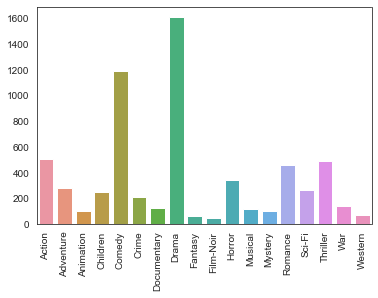

In [56]:
plt.xticks(rotation=90)
sns.barplot(x=movie_genre_df.columns, y =np.count_nonzero(movie_genre_df, axis=0))

Observation: A lot of movies have Drama genre followed by Comedy. While a very few movies on the platform have Film-Noir as the genre.

In [57]:
movies_df['Release Year'] = movies_df['Release Year'].astype('int')

In [58]:
movies_df['Release Year'].min(), movies_df['Release Year'].max()

(1919, 2000)

In [59]:
movies_df['Release Year'].value_counts()

1996    363
1995    341
1998    333
1997    315
1999    283
       ... 
1923      3
1919      3
1922      2
1920      2
1921      1
Name: Release Year, Length: 81, dtype: int64

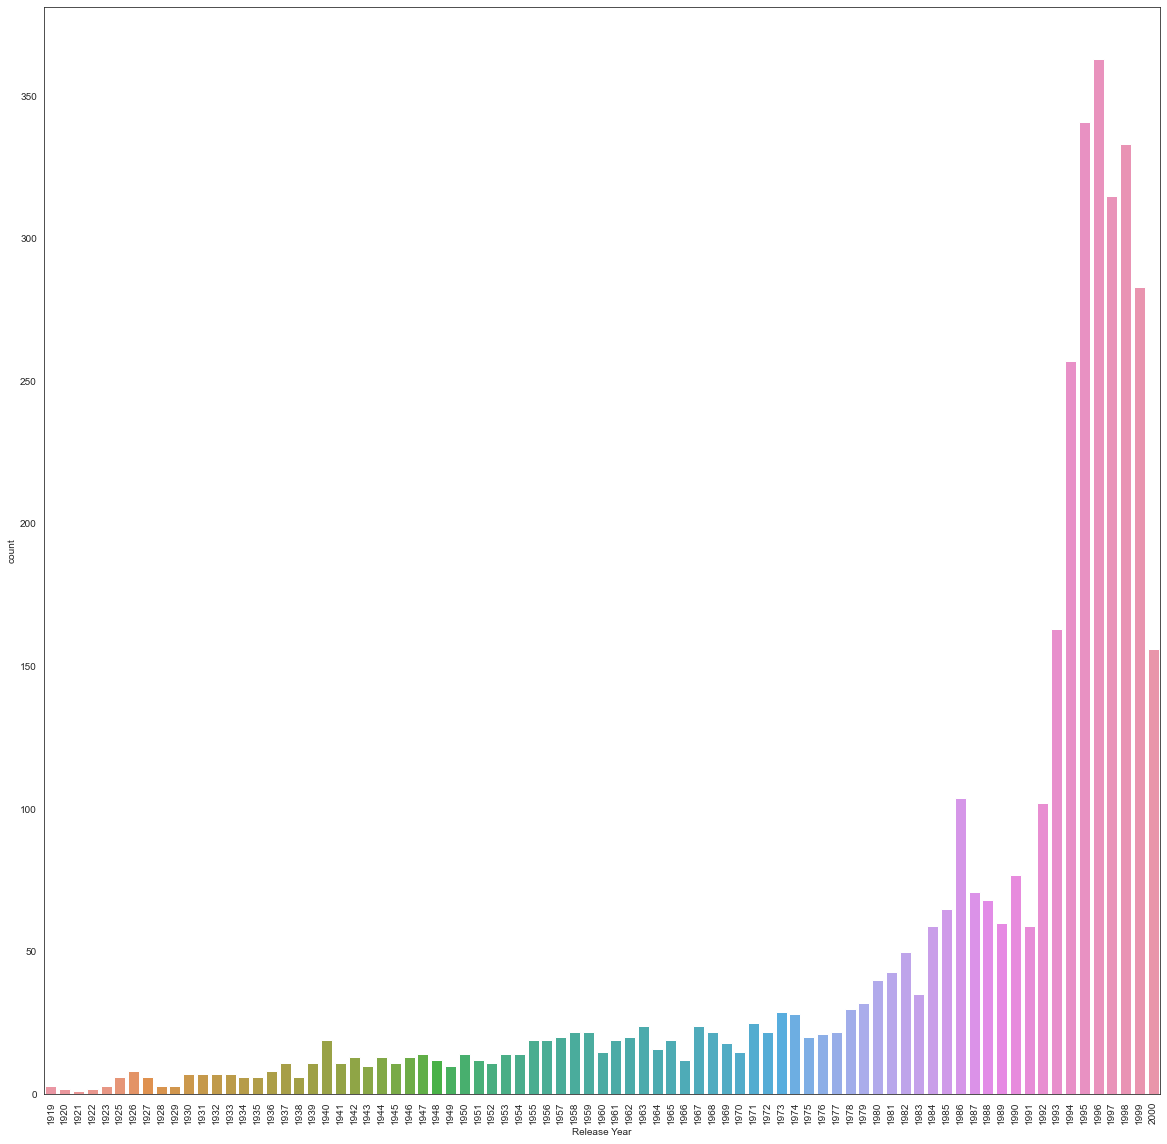

In [60]:
plt.figure(figsize=(20,20))
sns.countplot(movies_df['Release Year'])
plt.xticks(rotation=90)
plt.show()

Observation: Most of the movies on the platform were released after 1992.

## Analysis of the users data

In [61]:
users_df.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,Under 18,K-12 student,48067
1,2,M,56+,self-employed,70072
2,3,M,25-34,scientist,55117
3,4,M,45-49,executive/managerial,02460
4,5,M,25-34,writer,55455


In [62]:
users_df.Gender.nunique()

2

In [63]:
users_df.Gender.value_counts(),users_df.Gender.value_counts(normalize=True)

(M    4331
 F    1709
 Name: Gender, dtype: int64,
 M   0.72
 F   0.28
 Name: Gender, dtype: float64)

<AxesSubplot:xlabel='Gender', ylabel='count'>

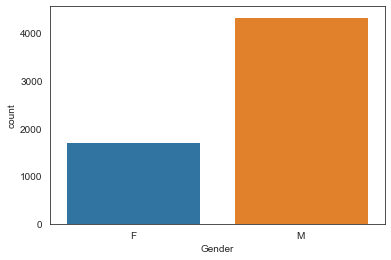

In [64]:
sns.countplot(users_df['Gender'])

Observation: 72% of the watchers on the platform are males while only 28% are females.

In [65]:
users_df.Age.value_counts(),users_df.Age.value_counts(normalize=True)

(25-34       2096
 35-44       1193
 18-24       1103
 45-49        550
 50-55        496
 56+          380
 Under 18     222
 Name: Age, dtype: int64,
 25-34      0.35
 35-44      0.20
 18-24      0.18
 45-49      0.09
 50-55      0.08
 56+        0.06
 Under 18   0.04
 Name: Age, dtype: float64)

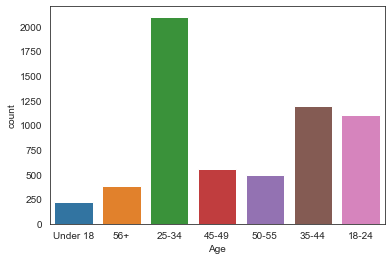

In [66]:
sns.countplot(users_df['Age'])
plt.show()

Observation: Most of the users are in their late 20s or early 30s.

In [67]:
users_df.Occupation.value_counts(),users_df.Occupation.value_counts(normalize=True)

(college/grad student    759
 other                   711
 executive/managerial    679
 academic/educator       528
 technician/engineer     502
 programmer              388
 sales/marketing         302
 writer                  281
 artist                  267
 self-employed           241
 doctor/health care      236
 K-12 student            195
 clerical/admin          173
 scientist               144
 retired                 142
 lawyer                  129
 customer service        112
 homemaker                92
 unemployed               72
 tradesman/craftsman      70
 farmer                   17
 Name: Occupation, dtype: int64,
 college/grad student   0.13
 other                  0.12
 executive/managerial   0.11
 academic/educator      0.09
 technician/engineer    0.08
 programmer             0.06
 sales/marketing        0.05
 writer                 0.05
 artist                 0.04
 self-employed          0.04
 doctor/health care     0.04
 K-12 student           0.03
 clerical/

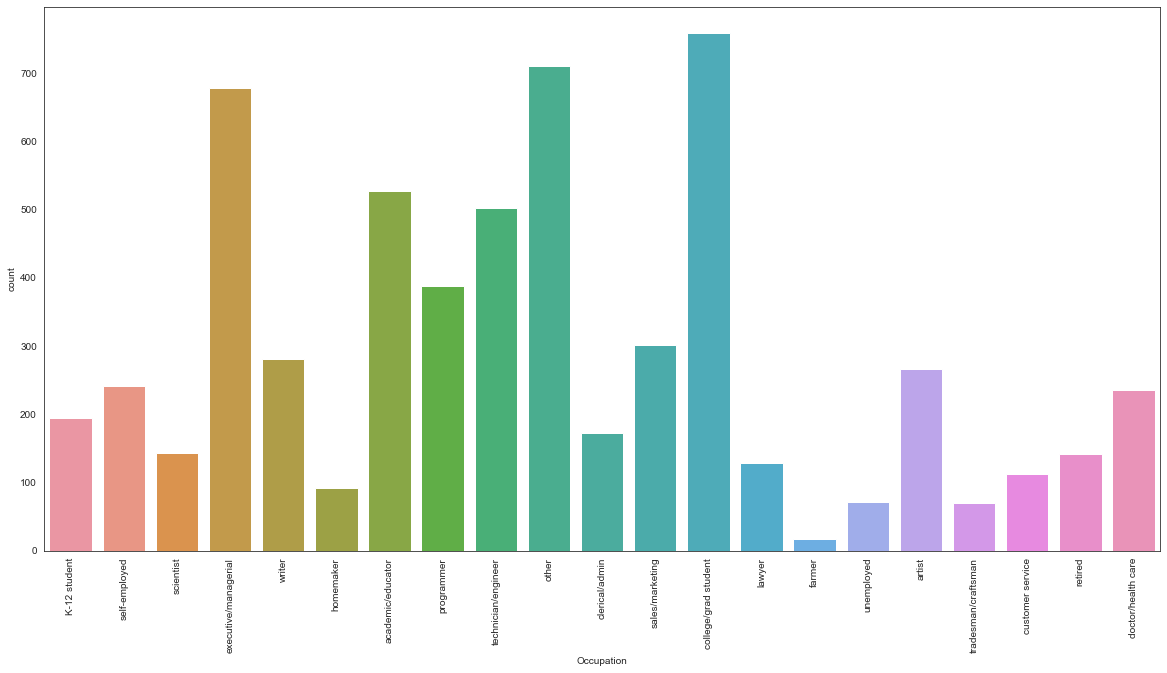

In [68]:
plt.figure(figsize=(20,10))
sns.countplot(users_df['Occupation'])
plt.xticks(rotation=90)
plt.show()

Observation: Max number of watchers are college/grad student followed by executive/managerial.

In [69]:
users_df['Zip-code'].value_counts().head(10)

48104    19
22903    18
55104    17
94110    17
55455    16
55105    16
10025    16
94114    15
55408    15
02138    15
Name: Zip-code, dtype: int64

## Analysis of the ratings data

In [70]:
ratings_df

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-06-01 23:38:11
...,...,...,...,...
1000204,6040,1091,1,2000-04-26 02:35:41
1000205,6040,1094,5,2000-04-25 23:21:27
1000206,6040,562,5,2000-04-25 23:19:06
1000207,6040,1096,4,2000-04-26 02:20:48


In [71]:
ratings_df['year'] = ratings_df['Timestamp'].dt.year
ratings_df['month'] = ratings_df['Timestamp'].dt.month
ratings_df['hour'] = ratings_df['Timestamp'].dt.hour

In [72]:
ratings_df.head()

,UserID,MovieID,Rating,Timestamp,year,month,hour
0,1,1193,5,2000-12-31 22:12:40,2000,12,22
1,1,661,3,2000-12-31 22:35:09,2000,12,22
2,1,914,3,2000-12-31 22:32:48,2000,12,22
3,1,3408,4,2000-12-31 22:04:35,2000,12,22
4,1,2355,5,2001-06-01 23:38:11,2001,6,23


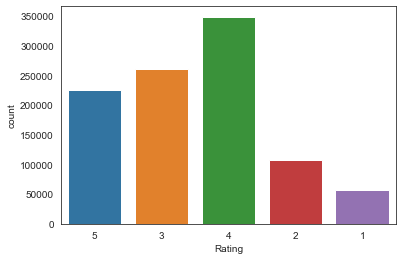

In [73]:
sns.countplot(ratings_df['Rating'])
plt.show()

Observation: Most users have rated most movies as 4.

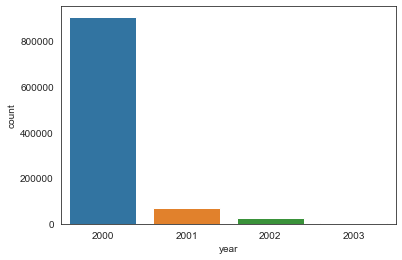

In [74]:
sns.countplot(ratings_df['year'])
plt.show()

Observation: Most of the ratings in the dataset were provided in the year 2000.

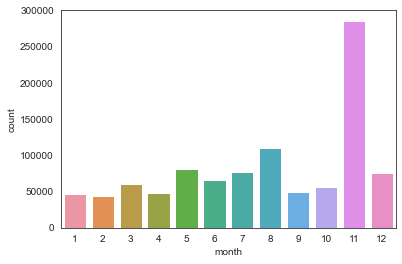

In [75]:
sns.countplot(ratings_df['month'])
plt.show()

Observation: Maximum content is being rated in November.

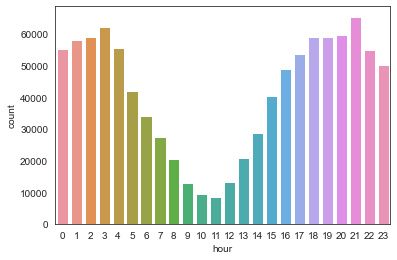

In [76]:
sns.countplot(ratings_df['hour'])
plt.show()

Observation: Morning and night are the fav times of people to watch and rate content.

In [77]:
ratings_df['Rating'] = ratings_df['Rating'].astype('int')

In [78]:
ratings_df.groupby(by='UserID').mean()['Rating']

UserID
1      4.19
10     4.11
100    3.03
1000   4.13
1001   3.65
       ... 
995    3.90
996    3.94
997    3.93
998    4.12
999    3.19
Name: Rating, Length: 6040, dtype: float64

In [79]:
ratings_df.groupby(by='UserID').count()['MovieID']

UserID
1        53
10      401
100      76
1000     84
1001    377
       ... 
995      49
996     296
997      30
998     135
999     412
Name: MovieID, Length: 6040, dtype: int64

In [80]:
ratings_df.groupby(by='MovieID').mean()['Rating']

MovieID
1      4.15
10     3.54
100    3.06
1000   3.05
1002   4.25
       ... 
994    4.10
996    2.91
997    3.36
998    3.01
999    3.28
Name: Rating, Length: 3706, dtype: float64

# Feature Engineering

In [81]:
users_df = users_df.merge(ratings_df.groupby(by='UserID').mean()['Rating'], how='left' ,on='UserID')
users_df = users_df.merge(ratings_df.groupby(by='UserID').count()['MovieID'], how='left' ,on='UserID')
users_df

,UserID,Gender,Age,Occupation,Zip-code,Rating,MovieID
0,1,F,Under 18,K-12 student,48067,4.19,53
1,2,M,56+,self-employed,70072,3.71,129
2,3,M,25-34,scientist,55117,3.90,51
3,4,M,45-49,executive/managerial,02460,4.19,21
4,5,M,25-34,writer,55455,3.15,198
...,...,...,...,...,...,...,...
6035,6036,F,25-34,scientist,32603,3.30,888
6036,6037,F,45-49,academic/educator,76006,3.72,202
6037,6038,F,56+,academic/educator,14706,3.80,20
6038,6039,F,45-49,other,01060,3.88,123


In [82]:
users_df.rename(columns={'Rating':'avg_rating', 'MovieID':'no_of_movies_rated'}, inplace=True)

In [83]:
users_df

,UserID,Gender,Age,Occupation,Zip-code,avg_rating,no_of_movies_rated
0,1,F,Under 18,K-12 student,48067,4.19,53
1,2,M,56+,self-employed,70072,3.71,129
2,3,M,25-34,scientist,55117,3.90,51
3,4,M,45-49,executive/managerial,02460,4.19,21
4,5,M,25-34,writer,55455,3.15,198
...,...,...,...,...,...,...,...
6035,6036,F,25-34,scientist,32603,3.30,888
6036,6037,F,45-49,academic/educator,76006,3.72,202
6037,6038,F,56+,academic/educator,14706,3.80,20
6038,6039,F,45-49,other,01060,3.88,123


In [84]:
movie_genre_df

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
MovieID,,,,,,,,,,,,,,,,,,
1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
100,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1000,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1001,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
996,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
997,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0


In [85]:
a = movies_df.merge(movie_genre_df.reset_index(), on='MovieID')
a

,MovieID,Title,Genres,Release Year,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,Animation|Children's|Comedy,1995,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji,Adventure|Children's|Fantasy,1995,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men,Comedy|Romance,1995,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale,Comedy|Drama,1995,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II,Comedy,1995,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,3948,Meet the Parents,Comedy,2000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3879,3949,Requiem for a Dream,Drama,2000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3880,3950,Tigerland,Drama,2000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3881,3951,Two Family House,Drama,2000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


# Build a Recommender System based on Pearson Correlation

In [86]:
X = a.iloc[:,4:].to_numpy()
X

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

In [87]:
z = np.argsort(-np.corrcoef(X))[:,:10]
z

array([[   0, 2286, 2285, ..., 3682, 2033, 2009],
       [2092,  124, 2330, ...,   59, 1006,   55],
       [ 903, 1171, 2528, ...,  797,  116,  814],
       ...,
       [1148, 1735, 3464, ...,  982, 3057, 2642],
       [1148, 1735, 3464, ...,  982, 3057, 2642],
       [3882,  227, 3441, ..., 3778, 1839, 3386]], dtype=int64)

In [88]:
rec = pd.DataFrame()
for i in range(len(movies_df)):
    rec[i] = pd.DataFrame(movies_df.loc[z[i]]['Title'].values)

In [89]:
rec= rec.T
rec

,0,1,2,3,4,5,6,7,8,9
0,Toy Story,"Bug's Life, A","Rugrats Movie, The",Toy Story 2,Aladdin and the King of Thieves,Saludos Amigos,"American Tail, An",Chicken Run,Steamboat Willie,"Jungle Book, The"
1,"NeverEnding Story, The","NeverEnding Story III, The",Santa Claus: The Movie,Escape to Witch Mountain,"Goonies, The",Labyrinth,Darby O'Gill and the Little People,"Indian in the Cupboard, The","20,000 Leagues Under the Sea",Kids of the Round Table
2,Sabrina,Strictly Ballroom,Lost & Found,"Couch in New York, A",Mifune (Mifunes sidste sang),Shakespeare in Love,She's the One,"Rendezvous in Paris (Rendez-vous de Paris, Les)",If Lucy Fell,Echte Kerle
3,Chuck & Buck,"Slingshot, The (Kådisbellan )","Reluctant Debutante, The","Van, The","Red Dwarf, The (Le Nain rouge)",Mass Transit,Spanking the Monkey,Taxman,Metroland,Ed Wood
4,"Road to Wellville, The",Metisse (Café au Lait),She-Devil,"Brady Bunch Movie, The",Who's That Girl?,Harry and the Hendersons,Who's Harry Crumb?,Volunteers,Shall We Dance? (Shall We Dansu?),Sprung
...,...,...,...,...,...,...,...,...,...,...
3878,"Road to Wellville, The",Metisse (Café au Lait),She-Devil,"Brady Bunch Movie, The",Who's That Girl?,Harry and the Hendersons,Who's Harry Crumb?,Volunteers,Shall We Dance? (Shall We Dansu?),Sprung
3879,Two or Three Things I Know About Her,"Callejón de los milagros, El","Actor's Revenge, An (Yukinojo Henge)","End of the Affair, The",Anna,"Sadness of Sex, The","Wooden Man's Bride, The (Wu Kui)",Big Night,"End of the Affair, The",My Life So Far
3880,Two or Three Things I Know About Her,"Callejón de los milagros, El","Actor's Revenge, An (Yukinojo Henge)","End of the Affair, The",Anna,"Sadness of Sex, The","Wooden Man's Bride, The (Wu Kui)",Big Night,"End of the Affair, The",My Life So Far
3881,Two or Three Things I Know About Her,"Callejón de los milagros, El","Actor's Revenge, An (Yukinojo Henge)","End of the Affair, The",Anna,"Sadness of Sex, The","Wooden Man's Bride, The (Wu Kui)",Big Night,"End of the Affair, The",My Life So Far


In [90]:
a = movies_df.copy()

In [91]:
rec = pd.merge(a, rec,left_index=True, right_index=True)
rec

,MovieID,Title,Genres,Release Year,0,1,2,3,4,5,6,7,8,9
0,1,Toy Story,Animation|Children's|Comedy,1995,Toy Story,"Bug's Life, A","Rugrats Movie, The",Toy Story 2,Aladdin and the King of Thieves,Saludos Amigos,"American Tail, An",Chicken Run,Steamboat Willie,"Jungle Book, The"
1,2,Jumanji,Adventure|Children's|Fantasy,1995,"NeverEnding Story, The","NeverEnding Story III, The",Santa Claus: The Movie,Escape to Witch Mountain,"Goonies, The",Labyrinth,Darby O'Gill and the Little People,"Indian in the Cupboard, The","20,000 Leagues Under the Sea",Kids of the Round Table
2,3,Grumpier Old Men,Comedy|Romance,1995,Sabrina,Strictly Ballroom,Lost & Found,"Couch in New York, A",Mifune (Mifunes sidste sang),Shakespeare in Love,She's the One,"Rendezvous in Paris (Rendez-vous de Paris, Les)",If Lucy Fell,Echte Kerle
3,4,Waiting to Exhale,Comedy|Drama,1995,Chuck & Buck,"Slingshot, The (Kådisbellan )","Reluctant Debutante, The","Van, The","Red Dwarf, The (Le Nain rouge)",Mass Transit,Spanking the Monkey,Taxman,Metroland,Ed Wood
4,5,Father of the Bride Part II,Comedy,1995,"Road to Wellville, The",Metisse (Café au Lait),She-Devil,"Brady Bunch Movie, The",Who's That Girl?,Harry and the Hendersons,Who's Harry Crumb?,Volunteers,Shall We Dance? (Shall We Dansu?),Sprung
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,3948,Meet the Parents,Comedy,2000,"Road to Wellville, The",Metisse (Café au Lait),She-Devil,"Brady Bunch Movie, The",Who's That Girl?,Harry and the Hendersons,Who's Harry Crumb?,Volunteers,Shall We Dance? (Shall We Dansu?),Sprung
3879,3949,Requiem for a Dream,Drama,2000,Two or Three Things I Know About Her,"Callejón de los milagros, El","Actor's Revenge, An (Yukinojo Henge)","End of the Affair, The",Anna,"Sadness of Sex, The","Wooden Man's Bride, The (Wu Kui)",Big Night,"End of the Affair, The",My Life So Far
3880,3950,Tigerland,Drama,2000,Two or Three Things I Know About Her,"Callejón de los milagros, El","Actor's Revenge, An (Yukinojo Henge)","End of the Affair, The",Anna,"Sadness of Sex, The","Wooden Man's Bride, The (Wu Kui)",Big Night,"End of the Affair, The",My Life So Far
3881,3951,Two Family House,Drama,2000,Two or Three Things I Know About Her,"Callejón de los milagros, El","Actor's Revenge, An (Yukinojo Henge)","End of the Affair, The",Anna,"Sadness of Sex, The","Wooden Man's Bride, The (Wu Kui)",Big Night,"End of the Affair, The",My Life So Far


In [92]:
('Toy Story' == rec[rec['Title'] == 'Toy Story'].iloc[0,4:]).index

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='object')

In [93]:
def recommend_movie_pearson(movie_title,n=5):
    recommendations = []
    index = (movies_df['Title'] == movie_title).idxmax()
    for candidate in (rec[rec['Title'] == movie_title].iloc[0,4:]):
        if(n>0):
            if(candidate==movie_title):
                continue
            else:
                recommendations.append(candidate)
                n-=1
    return recommendations

In [94]:
recommend_movie_pearson('Toy Story', n=8)

["Bug's Life, A",
 'Rugrats Movie, The',
 'Toy Story 2',
 'Aladdin and the King of Thieves',
 'Saludos Amigos',
 'American Tail, An',
 'Chicken Run',
 'Steamboat Willie']

# Build a Recommender System based on Cosine Similarity 

### Item based similarity

In [96]:
cosine_similarity(X)

array([[1.        , 0.33333333, 0.40824829, ..., 0.        , 0.        ,
        0.        ],
       [0.33333333, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.40824829, 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        0.70710678],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        0.70710678],
       [0.        , 0.        , 0.        , ..., 0.70710678, 0.70710678,
        1.        ]])

In [97]:
cos_sim_mtrx = np.argsort(-cosine_similarity(X))
cos_sim_mtrx

array([[   0, 1050, 2285, ..., 1564, 1550, 3882],
       [1974,    1,   59, ..., 1376, 1365, 3882],
       [2316,  925,  120, ..., 1604, 1585, 3882],
       ...,
       [3208, 2981, 3499, ..., 1688, 1725, 1941],
       [3208, 2981, 3499, ..., 1688, 1725, 1941],
       [3882, 2410, 2482, ..., 1855, 1838, 1941]], dtype=int64)

In [98]:
def recommend_movie_cosine(movie_title,n=5):
    recommendations = []
    index = int(movies_df[movies_df['Title']==movie_title].index[0])
    recom = cos_sim_mtrx[index]
    for candidate in recom:
        if(n>0):
            if(candidate==index):
                continue
            else:
                recommendations.append(movies_df.iloc[candidate]['Title'])
                n-=1
    return recommendations

In [231]:
recommend_movie_cosine('Toy Story',7)

['Aladdin and the King of Thieves',
 'Rugrats Movie, The',
 'American Tail, An',
 "Bug's Life, A",
 'Toy Story 2',
 'Chicken Run',
 'Saludos Amigos']

### User based similarity

In [100]:
users_df = pd.merge(users_df, pd.DataFrame(ratings_df.groupby('UserID').mean()['hour']), on='UserID')

In [101]:
users_df

,UserID,Gender,Age,Occupation,Zip-code,avg_rating,no_of_movies_rated,hour
0,1,F,Under 18,K-12 student,48067,4.19,53,22.25
1,2,M,56+,self-employed,70072,3.71,129,21.16
2,3,M,25-34,scientist,55117,3.90,51,21.00
3,4,M,45-49,executive/managerial,02460,4.19,21,20.00
4,5,M,25-34,writer,55455,3.15,198,6.02
...,...,...,...,...,...,...,...,...
6035,6036,F,25-34,scientist,32603,3.30,888,5.22
6036,6037,F,45-49,academic/educator,76006,3.72,202,1.60
6037,6038,F,56+,academic/educator,14706,3.80,20,7.40
6038,6039,F,45-49,other,01060,3.88,123,22.56


In [102]:
u

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
...,...,...,...,...,...
6035,6036,F,25,15,32603
6036,6037,F,45,1,76006
6037,6038,F,56,1,14706
6038,6039,F,45,0,01060


In [103]:
users_df

,UserID,Gender,Age,Occupation,Zip-code,avg_rating,no_of_movies_rated,hour
0,1,F,Under 18,K-12 student,48067,4.19,53,22.25
1,2,M,56+,self-employed,70072,3.71,129,21.16
2,3,M,25-34,scientist,55117,3.90,51,21.00
3,4,M,45-49,executive/managerial,02460,4.19,21,20.00
4,5,M,25-34,writer,55455,3.15,198,6.02
...,...,...,...,...,...,...,...,...
6035,6036,F,25-34,scientist,32603,3.30,888,5.22
6036,6037,F,45-49,academic/educator,76006,3.72,202,1.60
6037,6038,F,56+,academic/educator,14706,3.80,20,7.40
6038,6039,F,45-49,other,01060,3.88,123,22.56


In [104]:
u['avg_rating'] = users_df['avg_rating']
u['no_of_movies_rated'] = users_df['no_of_movies_rated']
u['hour'] = users_df['hour']

In [105]:
u

,UserID,Gender,Age,Occupation,Zip-code,avg_rating,no_of_movies_rated,hour
0,1,F,1,10,48067,4.19,53,22.25
1,2,M,56,16,70072,3.71,129,21.16
2,3,M,25,15,55117,3.90,51,21.00
3,4,M,45,7,02460,4.19,21,20.00
4,5,M,25,20,55455,3.15,198,6.02
...,...,...,...,...,...,...,...,...
6035,6036,F,25,15,32603,3.30,888,5.22
6036,6037,F,45,1,76006,3.72,202,1.60
6037,6038,F,56,1,14706,3.80,20,7.40
6038,6039,F,45,0,01060,3.88,123,22.56


In [106]:
le = LabelEncoder()
u['Gender'] = le.fit_transform(u['Gender'])

In [107]:
u.set_index('UserID',inplace=True)

In [108]:
u

,Gender,Age,Occupation,Zip-code,avg_rating,no_of_movies_rated,hour
UserID,,,,,,,
1,0,1,10,48067,4.19,53,22.25
2,1,56,16,70072,3.71,129,21.16
3,1,25,15,55117,3.90,51,21.00
4,1,45,7,02460,4.19,21,20.00
5,1,25,20,55455,3.15,198,6.02
...,...,...,...,...,...,...,...
6036,0,25,15,32603,3.30,888,5.22
6037,0,45,1,76006,3.72,202,1.60
6038,0,56,1,14706,3.80,20,7.40


In [109]:
u['Zip-code'] = u['Zip-code'].str.replace(r'[^0-9 ]+','',regex=True)

In [110]:
scaler = StandardScaler()
u = pd.DataFrame(scaler.fit_transform(u), columns=u.columns, index=u.index)

In [111]:
u

,Gender,Age,Occupation,Zip-code,avg_rating,no_of_movies_rated,hour
UserID,,,,,,,
1,-1.59,-2.30,0.29,-0.09,1.13,-0.58,1.41
2,0.63,1.97,1.24,-0.09,0.02,-0.19,1.26
3,0.63,-0.44,1.08,-0.09,0.46,-0.59,1.24
4,0.63,1.11,-0.18,-0.09,1.14,-0.75,1.10
5,0.63,-0.44,1.87,-0.09,-1.29,0.17,-0.86
...,...,...,...,...,...,...,...
6036,-1.59,-0.44,1.08,-0.09,-0.93,3.75,-0.97
6037,-1.59,1.11,-1.13,-0.09,0.04,0.19,-1.48
6038,-1.59,1.97,-1.13,-0.09,0.23,-0.76,-0.66


In [112]:
user_rec = ((-cosine_similarity(u)).argsort()+1)[:,:6]
user_rec

array([[   1, 5525,   86, 5989,  634, 5514],
       [   2, 1016, 2660,  724, 4171,  287],
       [   3, 4623, 5462, 5821,  359, 3862],
       ...,
       [6038,  986, 2183,  901,  347, 1634],
       [6039, 5430, 5024, 1455,  159, 2519],
       [6040, 4352, 1001, 4422, 2436, 3499]], dtype=int64)

In [113]:
type(user_rec[0][0])

numpy.int64

In [114]:
#movies_df['MovieID'] = movies_df['MovieID'].astype('int')
movies_df.set_index('MovieID', inplace=True)

In [115]:
movies_df['avg_rating'] = ratings_df.groupby('MovieID').mean()['Rating']
movies_df['avg_rating'].fillna(0, inplace=True)

In [116]:
def user_based_rec(UserID):
    user_movie_rec = []
    for i in user_rec[UserID-1]:
        user_movie_rec.append( np.setdiff1d(ratings_df[ratings_df['UserID']==str(i)]['MovieID'].values, ratings_df[ratings_df['UserID']==str(user_rec[UserID-1][0])]['MovieID'].values)) 
    user_movie_rec = np.concatenate(user_movie_rec)
    user_movie_rec = user_movie_rec.ravel()
    user_movie_rec = np.unique(user_movie_rec)
    rec_movies = movies_df.loc[user_movie_rec][movies_df.loc[user_movie_rec]['avg_rating'] >= np.floor(users_df.iloc[UserID-1]['avg_rating'])]
    return rec_movies

In [117]:
user_based_rec(1)

,Title,Genres,Release Year,avg_rating
MovieID,,,,
1196,Star Wars: Episode V - The Empire Strikes Back,Action|Adv,1980,4.29
1210,Star Wars: Episode VI - Return of the Jedi,Action|Adventu,1983,4.02
1537,Shall We Dance? (Shall We Dansu?),Comedy,1996,4.14
2324,Life Is Beautiful (La Vita è bella),Comedy|Drama,1997,4.33
2396,Shakespeare in Love,Comedy|Romance,1998,4.13
2501,October Sky,Drama,1999,4.14
2761,"Iron Giant, The",Animation|Children's,1999,4.05
2858,American Beauty,Comedy|Drama,1999,4.32
2908,Boys Don't Cry,Drama,1999,4.01


In [118]:
movie_genre_df

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
MovieID,,,,,,,,,,,,,,,,,,
1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
100,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1000,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1001,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
996,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
997,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0


In [119]:
movie_genre_df.values

array([[0, 0, 1, ..., 0, 0, 0],
       [1, 1, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [120]:
rm = ratings_df.pivot(index='UserID', columns='MovieID',values='Rating').fillna(0).astype(int)
rm.head()

MovieID  1  10  100  1000  1002  1003  1004  1005  1006  1007  1008  1009  \
UserID                                                                      
1        5   0    0     0     0     0     0     0     0     0     0     0   
10       5   0    0     0     0     0     0     0     0     0     0     5   
100      0   0    0     0     0     0     0     0     0     0     0     0   
1000     5   0    0     0     0     0     0     0     0     0     0     0   
1001     4   0    0     0     0     0     0     0     0     0     0     0   

MovieID  101  1010  1011  1012  1013  1014  1015  1016  1017  1018  1019  102  \
UserID                                                                          
1          0     0     0     0     0     0     0     0     0     0     0    0   
10         0     0     0     3     0     0     3     5     0     0     4    0   
100        0     0     0     0     0     0     0     0     0     0     0    0   
1000       0     0     0     0     0     0     0     0     0     0     0    0   
1001       0     0     0     0     0     0     0     0     0     0     0    0   

MovieID  1020  1021  1022  1023  1024  1025  1026  1027  1028  1029  103  \
UserID                                                                     
1           0     0     5     0     0     0     0     0     5     5    0   
10          3     0     5     5     0     4     0     0     5     0    0   
100         0     0     0     0     0     0     0     0     0     0    0   
1000        0     0     0     5     0     0     0     0     0     3    0   
1001        0     0     0     0     0     0     0     0     0     0    0   

MovieID  1030  1031  1032  1033  1034  1035  1036  1037  1038  1039  104  \
UserID                                                                     
1           0     0     0     0     0     5     0     0     0     0    0   
10          3     4     4     0     0     5     0     0     0     0    3   
100         0     0     0     0     0     0     0     0     0     0    0   
1000        0     0     0     0     0     0     4     0     0     0    0   
1001        0     0     0     0     0     0     0     0     0     0    0   

MovieID  1040  1041  1042  1043  1044  1046  1047  1049  105  1050  1051  \
UserID                                                                     
1           0     0     0     0     0     0     0     0    0     0     0   
10          0     0     5     0     0     0     0     0    0     0     0   
100         0     0     0     0     0     0     0     2    0     0     0   
1000        0     0     0     0     0     0     0     0    0     0     0   
1001        0     0     0     0     0     0     0     0    0     0     0   

MovieID  1053  1054  1055  1056  1057  1058  1059  106  1060  1061  1062  \
UserID                                                                     
1           0     0     0     0     0     0     0    0     0     0     0   
10          0     0     0     0     0     0     5    0     0     0     0   
100         0     0     0     0     0     0     0    0     0     0     0   
1000        0     0     0     0     0     0     0    0     0     0     0   
1001        0     0     0     0     0     0     2    0     0     0     0   

MovieID  1063  1064  1066  1067  1068  1069  107  1070  1071  1073  1076  \
UserID                                                                     
1           0     0     0     0     0     0    0     0     0     0     0   
10          0     0     0     0     0     0    0     0     0     5     0   
100         0     0     0     0     0     0    0     0     0     0     0   
1000        0     0     0     0     0     0    0     0     0     0     0   
1001        2     0     0     0     0     0    0     0     0     0     0   

MovieID  1077  1078  1079  108  1080  1081  1082  1083  1084  1085  1086  \
UserID                                                                     
1           0     0     0    0     0     0     0     0     0     0     0   

In [121]:
csr_mat = csr_matrix(rm.values)
csr_mat

<6040x3706 sparse matrix of type '<class 'numpy.intc'>'
	with 1000209 stored elements in Compressed Sparse Row format>

KNN algorithm to recommend 5 similar movies based on Cosine Similarity.

In [122]:
nbrs = NearestNeighbors(metric='cosine').fit(movie_genre_df.reset_index().to_numpy())
#nbrs = NearestNeighbors(metric='cosine').fit(csr_mat)

In [123]:
#dist, ind = nbrs.kneighbors(csr_mat)
dist, ind = nbrs.kneighbors(movie_genre_df.reset_index().to_numpy())

In [124]:
dist

array([[0.00000000e+00, 3.96977311e-01, 4.10744349e-01, 4.11651595e-01,
        4.26460665e-01],
       [0.00000000e+00, 8.12361142e-03, 9.81611555e-03, 1.07028211e-02,
        1.07221575e-02],
       [1.11022302e-16, 7.55814159e-07, 9.81707898e-07, 7.06252402e-06,
        2.90638586e-05],
       ...,
       [0.00000000e+00, 3.60004249e-11, 9.66531621e-09, 1.71027602e-08,
        2.09206362e-08],
       [0.00000000e+00, 1.95169001e-07, 3.13068790e-07, 3.23451325e-07,
        3.34865133e-07],
       [0.00000000e+00, 5.01043651e-13, 5.74028158e-10, 1.12120536e-08,
        2.86528741e-08]])

In [125]:
ind

array([[   0, 2165, 3227, 3338,  327],
       [   1,  537, 3774, 3272,  842],
       [   2, 3796,  121, 3654, 1245],
       ...,
       [3880,    6, 3784, 3756,  182],
       [3881,  828, 1345, 1398,  560],
       [3882,    3,   40, 3741,  343]], dtype=int64)

In [126]:
ind[0]

array([   0, 2165, 3227, 3338,  327], dtype=int64)

In [127]:
for i in ind[1]:
    print(movies_df.loc[str(i)])
    print("-----")

Title                             Toy Story
Genres          Animation|Children's|Comedy
Release Year                           1995
avg_rating                             4.15
Name: 1, dtype: object
-----
Title                 Sirens
Genres          Comedy|Drama
Release Year            1994
avg_rating              3.08
Name: 537, dtype: object
-----
Title           House Party 2
Genres                 Comedy
Release Year             1991
avg_rating               1.97
Name: 3774, dtype: object
-----
Title           Bad Lieutenant
Genres             Crime|Drama
Release Year              1992
avg_rating                3.20
Name: 3272, dtype: object
-----
Title           Tales from the Crypt Presents: Bordello of Blood
Genres                                                    Horror
Release Year                                                1996
avg_rating                                                  2.59
Name: 842, dtype: object
-----


# Build a Recommender System based on Matrix Factorization

### Using cmfrec library

In [132]:
rm = ratings_df.pivot(index='UserID', columns='MovieID',values='Rating').fillna(0).astype(int)
rm.head()

MovieID  1  10  100  1000  1002  1003  1004  1005  1006  1007  1008  1009  \
UserID                                                                      
1        5   0    0     0     0     0     0     0     0     0     0     0   
10       5   0    0     0     0     0     0     0     0     0     0     5   
100      0   0    0     0     0     0     0     0     0     0     0     0   
1000     5   0    0     0     0     0     0     0     0     0     0     0   
1001     4   0    0     0     0     0     0     0     0     0     0     0   

MovieID  101  1010  1011  1012  1013  1014  1015  1016  1017  1018  1019  102  \
UserID                                                                          
1          0     0     0     0     0     0     0     0     0     0     0    0   
10         0     0     0     3     0     0     3     5     0     0     4    0   
100        0     0     0     0     0     0     0     0     0     0     0    0   
1000       0     0     0     0     0     0     0     0     0     0     0    0   
1001       0     0     0     0     0     0     0     0     0     0     0    0   

MovieID  1020  1021  1022  1023  1024  1025  1026  1027  1028  1029  103  \
UserID                                                                     
1           0     0     5     0     0     0     0     0     5     5    0   
10          3     0     5     5     0     4     0     0     5     0    0   
100         0     0     0     0     0     0     0     0     0     0    0   
1000        0     0     0     5     0     0     0     0     0     3    0   
1001        0     0     0     0     0     0     0     0     0     0    0   

MovieID  1030  1031  1032  1033  1034  1035  1036  1037  1038  1039  104  \
UserID                                                                     
1           0     0     0     0     0     5     0     0     0     0    0   
10          3     4     4     0     0     5     0     0     0     0    3   
100         0     0     0     0     0     0     0     0     0     0    0   
1000        0     0     0     0     0     0     4     0     0     0    0   
1001        0     0     0     0     0     0     0     0     0     0    0   

MovieID  1040  1041  1042  1043  1044  1046  1047  1049  105  1050  1051  \
UserID                                                                     
1           0     0     0     0     0     0     0     0    0     0     0   
10          0     0     5     0     0     0     0     0    0     0     0   
100         0     0     0     0     0     0     0     2    0     0     0   
1000        0     0     0     0     0     0     0     0    0     0     0   
1001        0     0     0     0     0     0     0     0    0     0     0   

MovieID  1053  1054  1055  1056  1057  1058  1059  106  1060  1061  1062  \
UserID                                                                     
1           0     0     0     0     0     0     0    0     0     0     0   
10          0     0     0     0     0     0     5    0     0     0     0   
100         0     0     0     0     0     0     0    0     0     0     0   
1000        0     0     0     0     0     0     0    0     0     0     0   
1001        0     0     0     0     0     0     2    0     0     0     0   

MovieID  1063  1064  1066  1067  1068  1069  107  1070  1071  1073  1076  \
UserID                                                                     
1           0     0     0     0     0     0    0     0     0     0     0   
10          0     0     0     0     0     0    0     0     0     5     0   
100         0     0     0     0     0     0    0     0     0     0     0   
1000        0     0     0     0     0     0    0     0     0     0     0   
1001        2     0     0     0     0     0    0     0     0     0     0   

MovieID  1077  1078  1079  108  1080  1081  1082  1083  1084  1085  1086  \
UserID                                                                     
1           0     0     0    0     0     0     0     0     0     0     0   

In [133]:
rm_raw = ratings_df[['UserID', 'MovieID', 'Rating']].copy()
rm_raw.columns = ['UserId', 'ItemId', 'Rating']  # Lib requires specific column names
rm_raw.head(2)

,UserId,ItemId,Rating
0,1,1193,5
1,1,661,3


In [134]:
rm_raw['UserId'] = rm_raw['UserId'].astype('int')
rm_raw['ItemId'] = rm_raw['ItemId'].astype('int')

In [135]:
rm_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   UserId  1000209 non-null  int32
 1   ItemId  1000209 non-null  int32
 2   Rating  1000209 non-null  int32
dtypes: int32(3)
memory usage: 11.4 MB


In [136]:
model = CMF(k=4, lambda_=0.1, user_bias=False, item_bias=False, verbose=False)
model.fit(rm_raw)

Collective matrix factorization model
(explicit-feedback variant)


In [137]:
model.A_.shape

(6040, 4)

In [138]:
model.B_.shape

(3706, 4)

In [139]:
model.A_

array([[-0.12759057, -0.1526491 ,  0.07395583,  0.01498553],
       [-0.16667351, -0.1157693 , -0.26210436, -0.2708898 ],
       [-0.11924808,  0.0110383 , -0.3328297 ,  0.12727472],
       ...,
       [ 0.00311639, -0.12175434, -0.07501302, -0.24251589],
       [ 0.0184266 , -0.12406829, -0.155327  , -0.0996395 ],
       [ 0.41091388, -0.10115461, -0.21459958, -0.20569868]],
      dtype=float32)

In [140]:
top_items = model.topN(user=1, n=10)
top_items

array([1421, 1493, 2776, 1812, 3612, 2911, 1899, 2739, 3050, 1035])

In [141]:
movies_df.index

Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       ...
       '3943', '3944', '3945', '3946', '3947', '3948', '3949', '3950', '3951',
       '3952'],
      dtype='object', name='MovieID', length=3883)

In [142]:
top_items.astype('str')

array(['1421', '1493', '2776', '1812', '3612', '2911', '1899', '2739',
       '3050', '1035'], dtype='<U11')

In [144]:
movies_df

,Title,Genres,Release Year,avg_rating
MovieID,,,,
1,Toy Story,Animation|Children's|Comedy,1995,4.15
2,Jumanji,Adventure|Children's|Fantasy,1995,3.20
3,Grumpier Old Men,Comedy|Romance,1995,3.02
4,Waiting to Exhale,Comedy|Drama,1995,2.73
5,Father of the Bride Part II,Comedy,1995,3.01
...,...,...,...,...
3948,Meet the Parents,Comedy,2000,3.64
3949,Requiem for a Dream,Drama,2000,4.12
3950,Tigerland,Drama,2000,3.67


In [145]:
top_items = model.topN(user=1, n=10)
movies_df.loc[top_items.astype('str')]

,Title,Genres,Release Year,avg_rating
MovieID,,,,
1421,Grateful Dead,Documentary,1995,3.05
1493,Love and Other Catastrophes,Romance,1996,3.29
2776,"Marcello Mastroianni: I Remember Yes, I Remember",Document,1997,3.77
1812,Wide Awake,Children's|Comedy|Drama,1998,3.48
3612,"Slipper and the Rose, The",Adventure|Musical|Romance,1976,3.63
2911,"Grandfather, The (El Abuelo)",Drama,1998,3.29
1899,Passion in the Desert,Adventure|Drama,1998,3.20
2739,"Color Purple, The",Drama,1985,3.86
3050,Light It Up,Drama,1999,3.12


In [146]:
top_items = model.topN(user='3', n=10)
movies_df.loc[top_items.astype('str')]

,Title,Genres,Release Year,avg_rating
MovieID,,,,
3905,"Specials, The",Comedy,2000,3.88
2839,West Beirut (West Beyrouth),Drama,1998,4.30
53,Lamerica,Drama,1994,4.75
923,Citizen Kane,Drama,1941,4.39
670,"World of Apu, The (Apur Sansar)",Drama,1959,4.41
3817,"Other Side of Sunday, The (Søndagsengler)",Comedy|Drama,1996,3.19
3245,I Am Cuba (Soy Cuba/Ya Kuba),Drama,1964,4.80
3808,Two Women (La Ciociara),Drama|War,1961,4.02
922,Sunset Blvd. (a.k.a. Sunset Boulevard),Film-Noir,1950,4.49


### Model evaluation

In [147]:
rm__ = np.dot(model.A_, model.B_.T) + model.glob_mean_
mape(rm.values[rm > 0], rm__[rm > 0])**0.5

0.641492470334834

In [205]:
rm__ = np.dot(model.A_, model.B_.T) + model.glob_mean_
mse(rm.values[rm > 0], rm__[rm > 0])**0.5

1.4183050637155383

## D = 2 embeddings

In [148]:
model_2d = CMF(k=2, lambda_=0.1, user_bias=False, item_bias=False, verbose=False)
model_2d.fit(rm_raw)

Collective matrix factorization model
(explicit-feedback variant)


In [149]:
model_2d.B_.shape

(3706, 2)

In [150]:
model_2d.B_

array([[ 3.1528637e+00, -2.7971818e+00],
       [ 1.4257481e+00,  1.1954317e+00],
       [ 3.3362610e+00, -1.1772577e+00],
       ...,
       [-2.9723685e+00, -3.1745091e-01],
       [ 2.1051352e+00,  2.3618438e-03],
       [ 4.0806764e-01, -5.2076364e-01]], dtype=float32)

In [151]:
model_2d.B_[:,1:2]

array([[-2.7971818e+00],
       [ 1.1954317e+00],
       [-1.1772577e+00],
       ...,
       [-3.1745091e-01],
       [ 2.3618438e-03],
       [-5.2076364e-01]], dtype=float32)

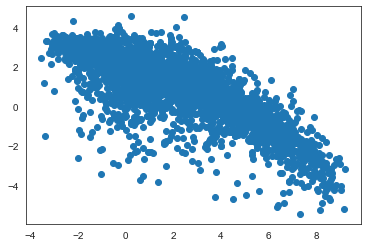

In [152]:
plt.scatter(y=model_2d.B_[:,:1] , x = model_2d.B_[:,1:2],)

Model evaluation

In [206]:
rm__ = np.dot(model_2d.A_, model_2d.B_.T) + model.glob_mean_
mape(rm.values[rm > 0], rm__[rm > 0])**0.5

0.6385276930007795

In [207]:
rm__ = np.dot(model_2d.A_, model_2d.B_.T) + model.glob_mean_
mse(rm.values[rm > 0], rm__[rm > 0])**0.5

1.3570805945512336

### Using Surprise library

In [155]:
df_1 = pd.merge(movies_df, ratings_df, how='inner', on='MovieID')
df_1.head()

,MovieID,Title,Genres,Release Year,avg_rating,UserID,Rating,Timestamp,year,month,hour
0,1,Toy Story,Animation|Children's|Comedy,1995,4.15,1,5,2001-06-01 23:37:48,2001,6,23
1,1,Toy Story,Animation|Children's|Comedy,1995,4.15,6,4,2000-12-31 04:30:08,2000,12,4
2,1,Toy Story,Animation|Children's|Comedy,1995,4.15,8,4,2000-12-31 03:31:36,2000,12,3
3,1,Toy Story,Animation|Children's|Comedy,1995,4.15,9,5,2000-12-31 01:25:52,2000,12,1
4,1,Toy Story,Animation|Children's|Comedy,1995,4.15,10,5,2000-12-31 01:34:34,2000,12,1


In [156]:
df_2 = pd.merge(df_1, users_df, how='inner', on='UserID')
df_2.head()

,MovieID,Title,Genres,Release Year,avg_rating_x,UserID,Rating,Timestamp,year,month,hour_x,Gender,Age,Occupation,Zip-code,avg_rating_y,no_of_movies_rated,hour_y
0,1,Toy Story,Animation|Children's|Comedy,1995,4.15,1,5,2001-06-01 23:37:48,2001,6,23,F,Under 18,K-12 student,48067,4.19,53,22.25
1,48,Pocahontas,Animation|Children's|Musical|Romance,1995,2.98,1,5,2001-06-01 23:39:11,2001,6,23,F,Under 18,K-12 student,48067,4.19,53,22.25
2,150,Apollo 13,Drama,1995,4.07,1,5,2000-12-31 22:29:37,2000,12,22,F,Under 18,K-12 student,48067,4.19,53,22.25
3,260,Star Wars: Episode IV - A New Hope,Action|Adventure|Fantas,1977,4.45,1,4,2000-12-31 22:12:40,2000,12,22,F,Under 18,K-12 student,48067,4.19,53,22.25
4,527,Schindler's List,Drama|War,1993,4.51,1,5,2001-06-01 23:36:35,2001,6,23,F,Under 18,K-12 student,48067,4.19,53,22.25


In [157]:
data = df_2[['UserID','MovieID','Rating']] #Considering only the userid, itemid and ratings
data.head()

,UserID,MovieID,Rating
0,1,1,5
1,1,48,5
2,1,150,5
3,1,260,4
4,1,527,5


In [158]:
data.isna().sum() #Checking for null values and no null values are present in the data

UserID     0
MovieID    0
Rating     0
dtype: int64

In [159]:
data.duplicated().sum() #Checking for the duplicates and no duplicate values present in the data

0

In [160]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 0 to 1000208
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   UserID   1000209 non-null  object
 1   MovieID  1000209 non-null  object
 2   Rating   1000209 non-null  int32 
dtypes: int32(1), object(2)
memory usage: 26.7+ MB


In [161]:
data['UserID'] = data['UserID'].astype('int')
data['MovieID'] = data['MovieID'].astype('int')

In [162]:
## The Reader class is used to parse a file containing ratings.It orders the data in format of (userid,title,rating) and even by considering the rating scale
reader = Reader(rating_scale=(0.5 , 5))
# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(data[['UserID','MovieID','Rating']], reader) # loading the data as per the format

In [163]:
anti_set = data.build_full_trainset().build_anti_testset()

In [164]:
trainset, testset = train_test_split(data, test_size=.15) # Splitting the data

In [165]:
algo = KNNWithMeans(k = 50, sim_options={'name': 'cosine', 'user_based': True}) 

# K value represents the (max) number of neighbors to take into account for aggregation. Example for every item it gives 50 nearest ones.
# There are many similarity options to calculate the similarity between the neighbors. Here, we have used the cosine similarity.
# when user_based = True then it performs user based collaborative filtering

algo.fit(trainset) #fitting the train dataset

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [166]:
# run the trained model against the testset
test_pred = algo.test(testset)

In [167]:
test_pred[0]

Prediction(uid=2340, iid=1267, r_ui=5.0, est=4.634301461040712, details={'actual_k': 50, 'was_impossible': False})

In [168]:
# get RMSE on test set
print("User-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

User-based Model : Test Set
RMSE: 0.9338


0.9338022612722648

In [216]:
# we can query for specific predicions
uid = 1  # raw user id
iid = 1  # raw item id

In [217]:
# get a prediction for specific users and items.
pred = algo.predict(uid, iid, verbose=True)

user: 1          item: 1          r_ui = None   est = 4.78   {'actual_k': 50, 'was_impossible': False}


In [227]:
ratings_df[ratings_df['UserID']=='1'][ratings_df[ratings_df['UserID']=='1']['MovieID']==1]

,UserID,MovieID,Rating,Timestamp,year,month,hour
40,1,1,5,2001-06-01 23:37:48,2001,6,23


For this user 1 for movie 1 the true rating is 5 where as the estimated rating is 4.78

In [172]:
#anti_pre = algo.test(anti_set)
#pred_df = pd.DataFrame(anti_pre).merge(movies_df , left_on = ['iid'], right_on = ['MovieID'])
#pred_df = pd.DataFrame(pred_df).merge(users_df , left_on = ['uid'], right_on = ['UserID'])

Running the test on anti_set data which was really large dataset took alot of time, hence was not done.

In [173]:
# K value represents the (max) number of neighbors to take into account for aggregation. Example for every item it gives 50 nearest ones.
# There are many similarity options to calculate the similarity between the neighbors . Here, we have used the cosine similarity.
# when user_based = False then it performs item based collaborative filtering

algo_i = KNNWithMeans(k=50, sim_options={'name': 'cosine', 'user_based': False})
algo_i.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [174]:
# run the trained model against the testset
test_pred = algo_i.test(testset)

In [175]:
test_pred[0]

Prediction(uid=2340, iid=1267, r_ui=5.0, est=4.900752170343623, details={'actual_k': 50, 'was_impossible': False})

In [176]:
# get RMSE on test set
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 0.8898


0.8898268742367075

In [177]:
# we can query for specific predicions
uid = 196  # raw user id
iid = 303  # raw item id

In [178]:
# get a prediction for specific users and items.
pred = algo_i.predict(uid, iid, verbose=True)

user: 196        item: 303        r_ui = None   est = 2.91   {'actual_k': 28, 'was_impossible': False}


In [179]:
movies_df.reset_index(inplace=True)

In [180]:
movies_df.MovieID = movies_df.MovieID.astype('int')

In [181]:
tsr_inner_id = algo_i.trainset.to_inner_iid(1) #Considering the movieId 1

tsr_neighbors = algo_i.get_neighbors(tsr_inner_id, k=5) #Getting the 5 nearest neighbors for movieId 1

movies_df[movies_df.MovieID.isin([algo.trainset.to_raw_iid(inner_id)
                       for inner_id in tsr_neighbors])] #Displaying the 5 nearest neighbors to the Toy Story.

,MovieID,Title,Genres,Release Year,avg_rating
689,698,Delta of Venus,Drama,1994,2.20
1060,1076,"Innocents, The",Thriller,1961,4.00
1671,1720,Time Tracers,Action|Adventure|Sci-Fi,1995,1.29
2150,2219,Murder!,Mystery|Thriller,1930,3.40
3572,3641,"Woman of Paris, A",Drama,1923,2.75


In [182]:
svd = SVD() #Suprise library uses the SVD algorithm to perform the matrix factorisation where as other libraries uses ALS
cross_validate(svd, data, measures=['rmse','mae'], cv = 5 , return_train_measures=True,verbose=True)
##The dataset is divided into train and test and with 5 folds the rmse has been calculated

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8713  0.8736  0.8739  0.8755  0.8773  0.8743  0.0020  
MAE (testset)     0.6845  0.6857  0.6857  0.6874  0.6893  0.6865  0.0017  
RMSE (trainset)   0.6700  0.6698  0.6705  0.6707  0.6701  0.6702  0.0003  
MAE (trainset)    0.5300  0.5299  0.5306  0.5304  0.5303  0.5303  0.0003  
Fit time          7.51    7.66    7.62    7.59    7.63    7.60    0.05    
Test time         1.33    1.89    0.91    0.93    1.38    1.29    0.36    


{'test_rmse': array([0.87134697, 0.87355262, 0.8739018 , 0.8754841 , 0.87728872]),
 'train_rmse': array([0.67001296, 0.66983483, 0.67045264, 0.67067493, 0.67005786]),
 'test_mae': array([0.68453931, 0.68570371, 0.68565757, 0.68742634, 0.68933172]),
 'train_mae': array([0.52995999, 0.52993446, 0.53063394, 0.5304089 , 0.53034117]),
 'fit_time': (7.512232780456543,
  7.656111478805542,
  7.623978614807129,
  7.591007947921753,
  7.625606536865234),
 'test_time': (1.333268404006958,
  1.885216474533081,
  0.9056599140167236,
  0.930166482925415,
  1.383906602859497)}

In [183]:
trainset = data.build_full_trainset()
svd.fit(trainset) ##Fitting the trainset with the help of svd

In [184]:
svd.pu.shape , svd.qi.shape #pu gives the embeddings of Users and qi gives the embeddings of Items.

((6040, 100), (3706, 100))

In [185]:
#Storing all the movie titles in items
items = movies_df['Title'].unique()
##Considering the user '662' 
test = [[662, iid, 4] for iid in items]
##Finding the user predictions(ratings) for all the movies
predictions = svd.test(test)
pred = pd.DataFrame(predictions)

In [186]:
a = pred.sort_values(by='est', ascending=False) ##Sorting the values based on the estimated predictions

In [187]:
a[0:10] ##TOP 10

,uid,iid,r_ui,est,details
0,662,Toy Story,4,3.47,{'was_impossible': False}
1921,662,Poltergeist III,4,3.47,{'was_impossible': False}
2553,662,House of Frankenstein,4,3.47,{'was_impossible': False}
2554,662,Frankenstein,4,3.47,{'was_impossible': False}
2555,662,Son of Frankenstein,4,3.47,{'was_impossible': False}
2556,662,"Ghost of Frankenstein, The",4,3.47,{'was_impossible': False}
2557,662,Frankenstein Meets the Wolf Man,4,3.47,{'was_impossible': False}
2558,662,"Curse of Frankenstein, The",4,3.47,{'was_impossible': False}
2559,662,Son of Dracula,4,3.47,{'was_impossible': False}
2560,662,"Wolf Man, The",4,3.47,{'was_impossible': False}


In [188]:
testset = trainset.build_anti_testset()
predictions_svd = svd.test(testset) #Predicting for the test set

In [189]:
print('SVD - RMSE:', accuracy.rmse(predictions_svd, verbose=False))
print('SVD - MAE:', accuracy.mae(predictions_svd, verbose=False))

SVD - RMSE: 0.7000037920339579
SVD - MAE: 0.5420492450411164


# Questionnaire:

1. Users of which age group have watched and rated the most number of movies?

In [235]:
df['Age'].value_counts()

25-34       395556
35-44       199003
18-24       183536
45-49        83633
50-55        72490
56+          38780
Under 18     27211
Name: Age, dtype: int64

Ans: 25-34 have watched and rated the most number of movies.

2. Users belonging to which profession have watched and rated the most movies?

In [237]:
df.Occupation.value_counts()

college/grad student    131032
other                   130499
executive/managerial    105425
academic/educator        85351
technician/engineer      72816
writer                   60397
programmer               57214
artist                   50068
sales/marketing          49109
self-employed            46021
doctor/health care       37205
clerical/admin           31623
K-12 student             23290
scientist                22951
customer service         21850
lawyer                   20563
unemployed               14904
retired                  13754
tradesman/craftsman      12086
homemaker                11345
farmer                    2706
Name: Occupation, dtype: int64

Ans: college/grad student have watched and rated the most movies.

3. Most of the users in our dataset who’ve rated the movies are Male. (T/F)

In [240]:
df.Gender.value_counts()

M    753769
F    246440
Name: Gender, dtype: int64

Ans: True. 

4. Most of the movies present in our dataset were released in which decade?

a. 70s b. 90s c. 50s d.80s

In [243]:
movies_df['Release Year'].value_counts()

1996    363
1995    341
1998    333
1997    315
1999    283
       ... 
1923      3
1919      3
1922      2
1920      2
1921      1
Name: Release Year, Length: 81, dtype: int64

Ans: b. 90s

5. The movie with maximum no. of ratings is ___.

In [253]:
df[df['MovieID'] == df.groupby(by='MovieID').count()['Rating'].sort_values(ascending=False).index[0]]['Title'].unique()

array(['American Beauty (1999)'], dtype=object)

Ans: The movie with maximum no. of ratings is American Beauty

6. Name the top 3 movies similar to ‘Liar Liar’ on the item-based approach.

In [258]:
recommend_movie_cosine('Liar Liar', 3)

['Loser', 'Castle, The', "Bustin' Loose"]

Ans: top 3 movies similar to ‘Liar Liar’ on the item-based approach are:
    
    1. Loser
    
    2. Castle, The
    
    3. Bustin' Loose

7. On the basis of approach, Collaborative Filtering methods can be classified into ___-based and ___-based.

Ans: On the basis of approach, Collaborative Filtering methods can be classified into user-based and item-based.

8. Pearson Correlation ranges between ___ to ___ whereas, Cosine Similarity belongs to the interval between ___ to ___.

Ans: Pearson Correlation ranges between -1 to 1 whereas, Cosine Similarity belongs to the interval between 0 to 1.

9. Mention the RMSE and MAPE that you got while evaluating the Matrix Factorization model.

Ans: RMSE: 0.64
     MAPE: 1.35

10. Give the sparse ‘row’ matrix representation for the following dense matrix -

[[1 0]
[3 7]]

In [286]:
x = np.array([[1,0],[3,7]])
csr_matrix(x).toarray()

array([[1, 0],
       [3, 7]], dtype=int32)

Ans: The sparse row matrix representation for the given dense matrix is:
[(0, 0, 1), (1, 0, 3), (1, 1, 7)].